In [49]:
'''
__author__ = 'Alex Cheng'
ensemble集成方法：bagging, boosting, RF

Baggin算法：bootstrap，每一个样本集训练一个基学习器，回归问题，结果为均值，
            分类问题是从不同类别所占的百分比引申出来各种类别的概率和均值

bootstrap: 有放回采样
最终预测结果取各个基学习器预测的平均值

深度为1的决策树的集成方法相对于当个决策树在均方误差方面的改善可以忽略不计
红酒数据有多个属性，因此多个属性的组合对预测的贡献要远大于单独每个属性对预测的贡献


'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import datasets,linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.externals.six import StringIO
from math import sqrt
import random

In [50]:
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
"wine-quality/winequality-red.csv")
df = pd.read_csv(target_url,header=0,sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [51]:
xList  = np.array(df.iloc[:,:-1]) # 属性数组
labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
names = df.columns

# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# 固定 30%采样
nsample = int(nrows * 0.30)
idxTest = random.sample(range(nrows),nsample) # 随机30%抽取
idxTest.sort()
idxTrain = [idx for idx in range(nrows) if not(idx in idxTest)]

# 定义测试和训练的属性和列表
xTrain = [xList[r] for r in idxTrain]
xTest  = [xList[r] for r in idxTest]
yTrain = [labels[r] for r in idxTrain]
yTest  = [labels[r] for r in idxTest] # 列向量

30


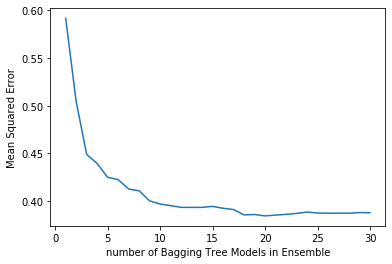

Min MSE with Bagging treeDepth 5 maxTree 30 : 0.384282162679641


In [52]:
numTreeMax = 30
treeDepth = 5
modelList = []
predList = []

nBagSamples = int(len(xTrain) * 0.5)

# 30个bootstrap抽样的决策树模型
for iTree in range(numTreeMax):
    idxBag = []
    # 每次不同的采样,以下是没有放回的
    #idxBag = random.sample(range(len(xTrain)),range(nBagSamples))
    # Bag是有放回的, 所以random.chioce
    for i in range(nBagSamples):
        idxBag.append(random.choice(range(len(xTrain))))
    
    xSample = [xTrain[i] for i in idxBag]
    ySample = [yTrain[i] for i in idxBag]
    modelList.append(DecisionTreeRegressor(max_depth=treeDepth))
    modelList[-1].fit(xSample,ySample)
    
    latestPred = modelList[-1].predict(xTest) # 每个模型的预知
    predList.append(list(latestPred))
print(len(predList))

# 前n个决策树模型的累计
allPred = []
mse = []
for iModel in range(len(modelList)): # 注意，不要有0棵树的
    modelPred = []
    for iTest in range(len(xTest)):
        pred = sum([predList[i][iTest] for i in range(iModel+1 )]) / (iModel + 1) # 前iModel个树，对第iTest个测试数据的预测平均值
        modelPred.append(pred)
    allPred.append(modelPred)
    #print(len(allPred),len(allPred[0]))
    
    # 检查错误
    errors = [allPred[iModel][j] - yTest[j] for j in range(len(xTest))]
    mse.append(sum([e * e for e in errors]) / len(yTest))

nModels = [i+1 for i in range(len(modelList))]
plt.plot(nModels,mse)
plt.axis('tight')
plt.xlabel('number of Bagging Tree Models in Ensemble')
plt.ylabel('Mean Squared Error')
#plt.ylim(0.0,max(mse))
plt.show() 

print('Min MSE with Bagging treeDepth',treeDepth,'maxTree',numTreeMax, ":", min(mse))
